# Determining optimal window size for brain to text prediction
In this noteboook, we want to find out, which window size is best suitable for brain to text prediction.

1. Argmax window size maximizing correlation between the different features/nodes
2. Understand geometry of the data by PCA
3. Apply findings to the raw data to achieve greater suitability for sentence prediction

In [1]:
import pandas as pd
import numpy as np
from src.datasets.brain2text import Brain2TextDataset
from src.args.yaml_config import YamlConfig
from src.args.base_args import B2TDatasetArgsModel
from src.analysis.helpers import pca_most_valuable_features, show_corr_matrix
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from math import floor
import random
from tqdm import tqdm


yaml_config = YamlConfig().config
ds_config = B2TDatasetArgsModel()

In [2]:
def calculate_correlation(df: pd.DataFrame, bin_len: int, max_bin_len: int, bin_len_penalty: float):
    resampled_df = df.resample(f"{bin_len}L").mean().interpolate()
    corr_matrix = resampled_df.corr()
    penalty = bin_len_penalty * (bin_len / max_bin_len)
    avg_corr = np.mean(np.mean(corr_matrix))
    return avg_corr, avg_corr * (1.0 - penalty)

def get_optimal_window(df: pd.DataFrame, max_bin_len: int, bin_len_penalty: float, verbose: bool = False):
    min_bin_len = 5
    # At least two bins per sample
    bin_len_step = 5

    corr_scores = []
    avg_corrs = []

    bin_lens_to_check = range(min_bin_len, max_bin_len, bin_len_step)
    for bin_len in bin_lens_to_check:
        avg_corr, corr_score = calculate_correlation(df, bin_len, max_bin_len, bin_len_penalty)
        corr_scores.append(corr_score)
        avg_corrs.append(avg_corr)
        
    opt_idx = np.argmax(corr_scores)
    opt_bin_len = bin_lens_to_check[opt_idx]
    max_corr_score = corr_scores[opt_idx]
    
    
    if verbose:
        plt.plot(bin_lens_to_check, corr_scores, label='Corr score with window length penalty')
        plt.plot(bin_lens_to_check, avg_corrs, label='Average correlation between features')
        plt.xlabel('Window Size (ms)')
        plt.ylabel('Average Correlation')
        plt.title('Correlation vs. Window Size', y=1.04, fontsize=12)
        plt.suptitle(f"Maximum correlation: {opt_bin_len} ms with {max_corr_score:.4f} mean correlation score", y=0.92, fontsize=10)
        plt.grid(True)
        plt.legend()
        plt.show()
        plt.close()
    
    return opt_bin_len, avg_corrs[opt_idx]

def pca_analysis(data: pd.DataFrame, bin_len: int, verbose: bool = False):
    df_res = data.resample(f"{bin_len}L").mean().interpolate(method='linear')
    pca = PCA(n_components=min(len(df_res), len(df_res.columns)))
    pcs = pca.fit_transform(df_res)
    
    index_95 = pca_most_valuable_features(pca, 0.95)
    index_50 = pca_most_valuable_features(pca, 0.50)

    if verbose:
        print(f"PCA features\n50% of data: {index_50}, 95% of data: {index_95}")
    return index_95

def analyze_sentence(data, max_bin_len: int, verbose: bool = False):
    time_series_idx = pd.to_timedelta(np.arange(0, data.shape[0]) * 20, unit='ms')
    df = pd.DataFrame(data, index=time_series_idx)
    if verbose:
        show_corr_matrix(df, -0.5, 0.5)
        
    time_bin_lens = []
    avg_corrs = []
    idx_95_arr = []
    for bin_len_penalty in [0.0, 0.5]:
        if verbose:
            print(f'Analyzing sentence with bin len penalty {bin_len_penalty}')
        time_bin_len, avg_corr = get_optimal_window(df, max_bin_len, bin_len_penalty, verbose)
        time_bin_lens.append(time_bin_len)
        avg_corrs.append(avg_corr)
        index_95 = pca_analysis(df, time_bin_len, verbose)
        idx_95_arr.append(index_95)
    return time_bin_lens, avg_corrs, idx_95_arr

## Looking at single sentence
We will first look at a single sentence and will apply the steps above to it.

In [3]:
# ds_config.preprocessing = 'only_spikepow_zscored'
np_samples = [sample.numpy() for sample in Brain2TextDataset(ds_config, yaml_config, 'train').brain_data_samples]
time_bins_per_sample = np.array([sample.shape[0] for sample in np_samples])

median_bins_per_sample = np.median(time_bins_per_sample)
min_bins_per_sample = time_bins_per_sample.min()
max_bin_len = 100 #floor(min_bins_per_sample / 4) * 20

idx = np.argmax(time_bins_per_sample)

sentence_idxs = random.sample(range(0, len(np_samples)), 3)

sentences = [np_samples[i] for i in sentence_idxs]

Got tokenizer from file


:::::::  ANALYZING SENTENCE #0 - Recording length: 4100 ms  :::::::


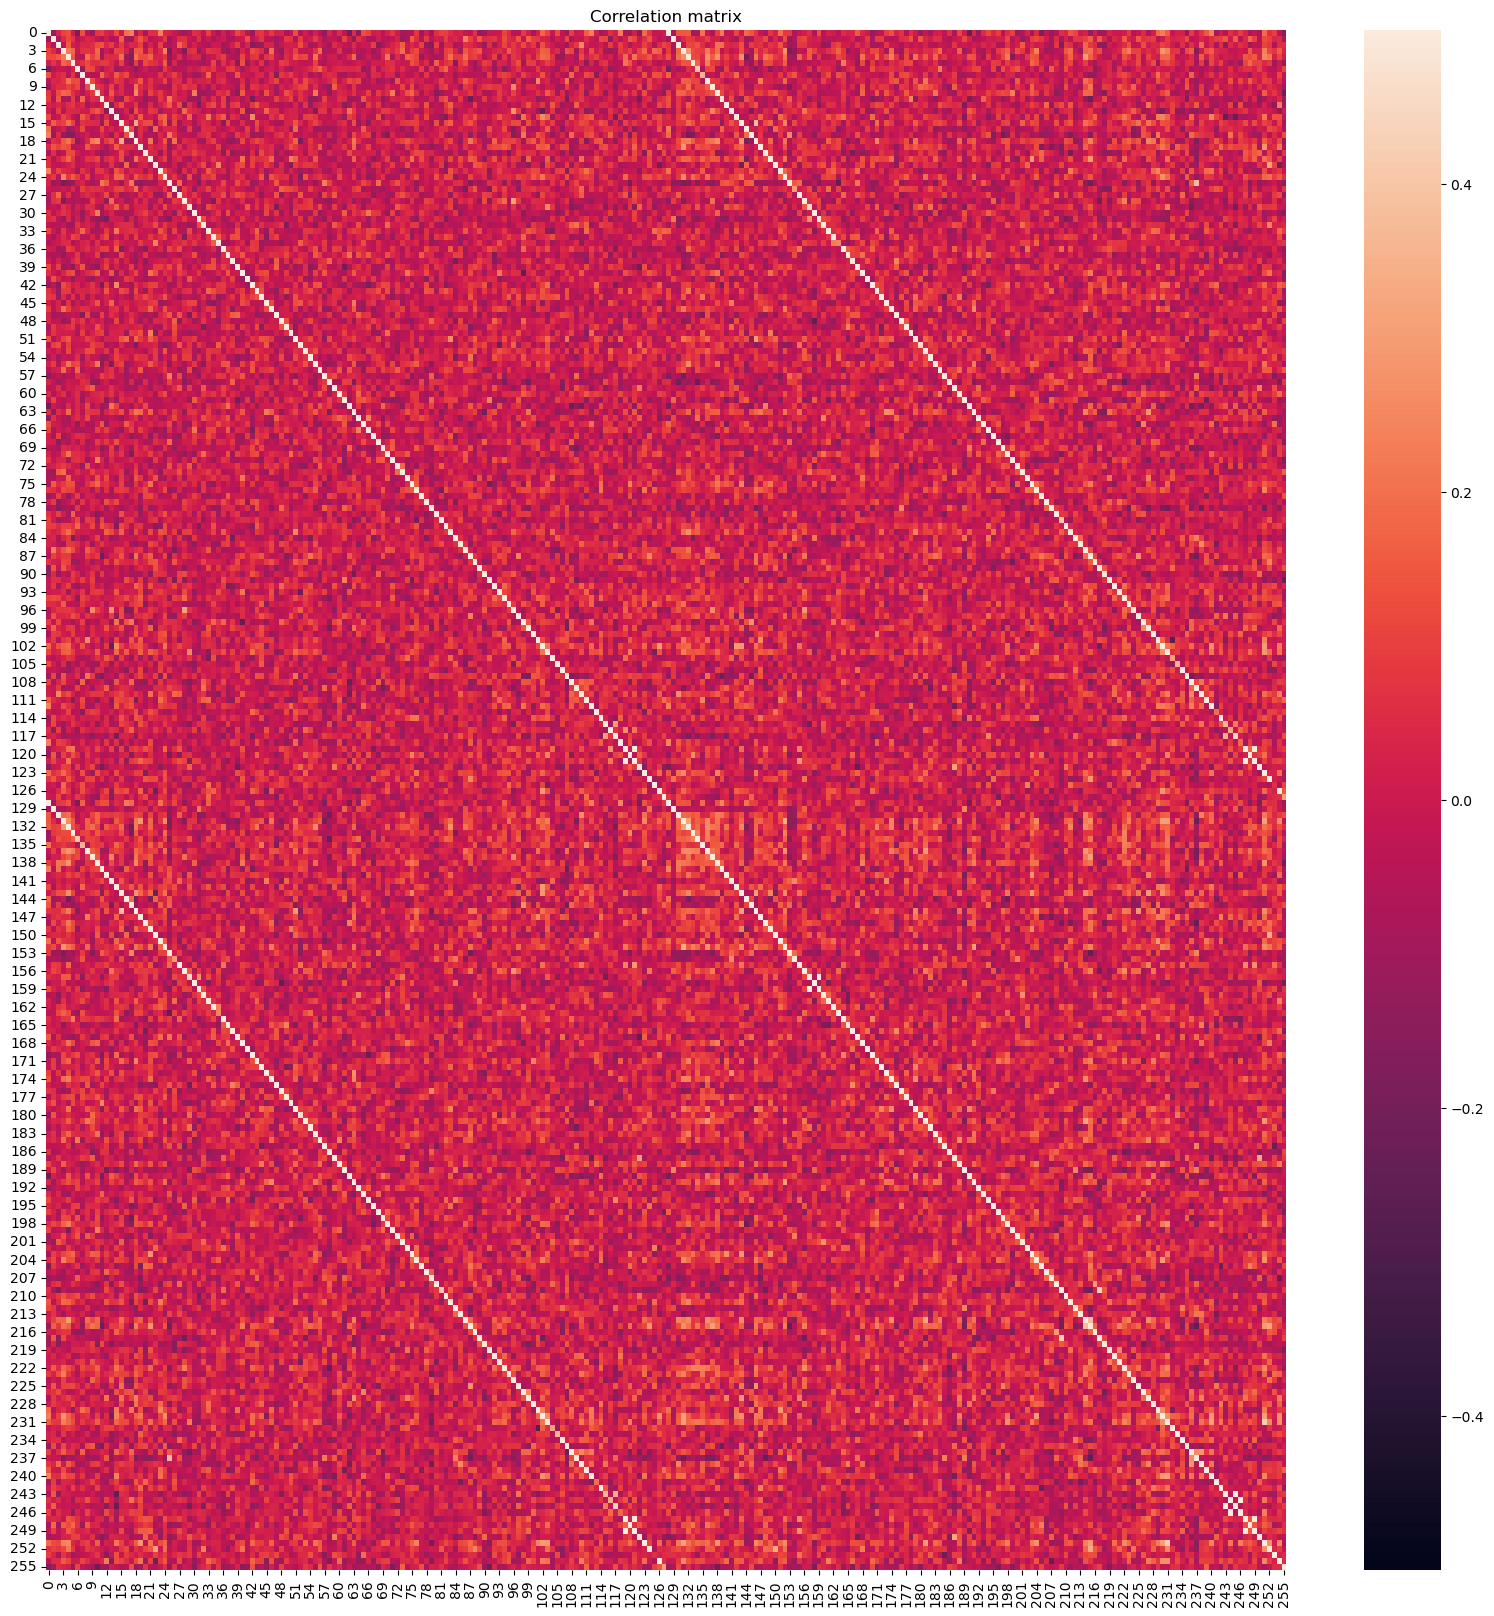

Analyzing sentence with bin len penalty 0.0


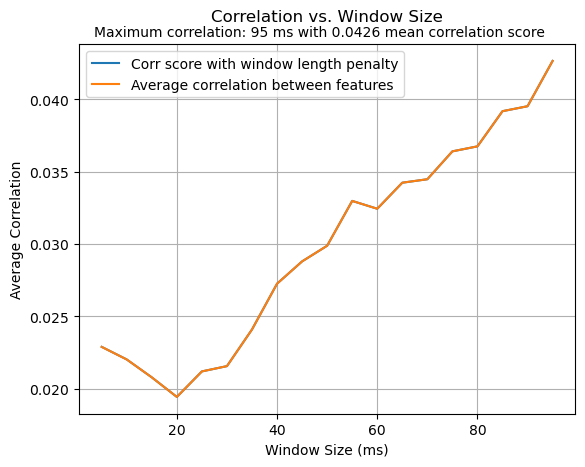

PCA features
50% of data: 7, 95% of data: 34
Analyzing sentence with bin len penalty 0.5


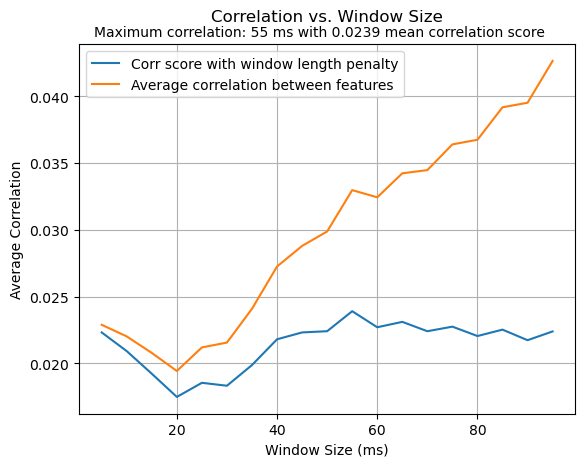

PCA features
50% of data: 12, 95% of data: 57
:::::::  ANALYZING SENTENCE #1 - Recording length: 5060 ms  :::::::


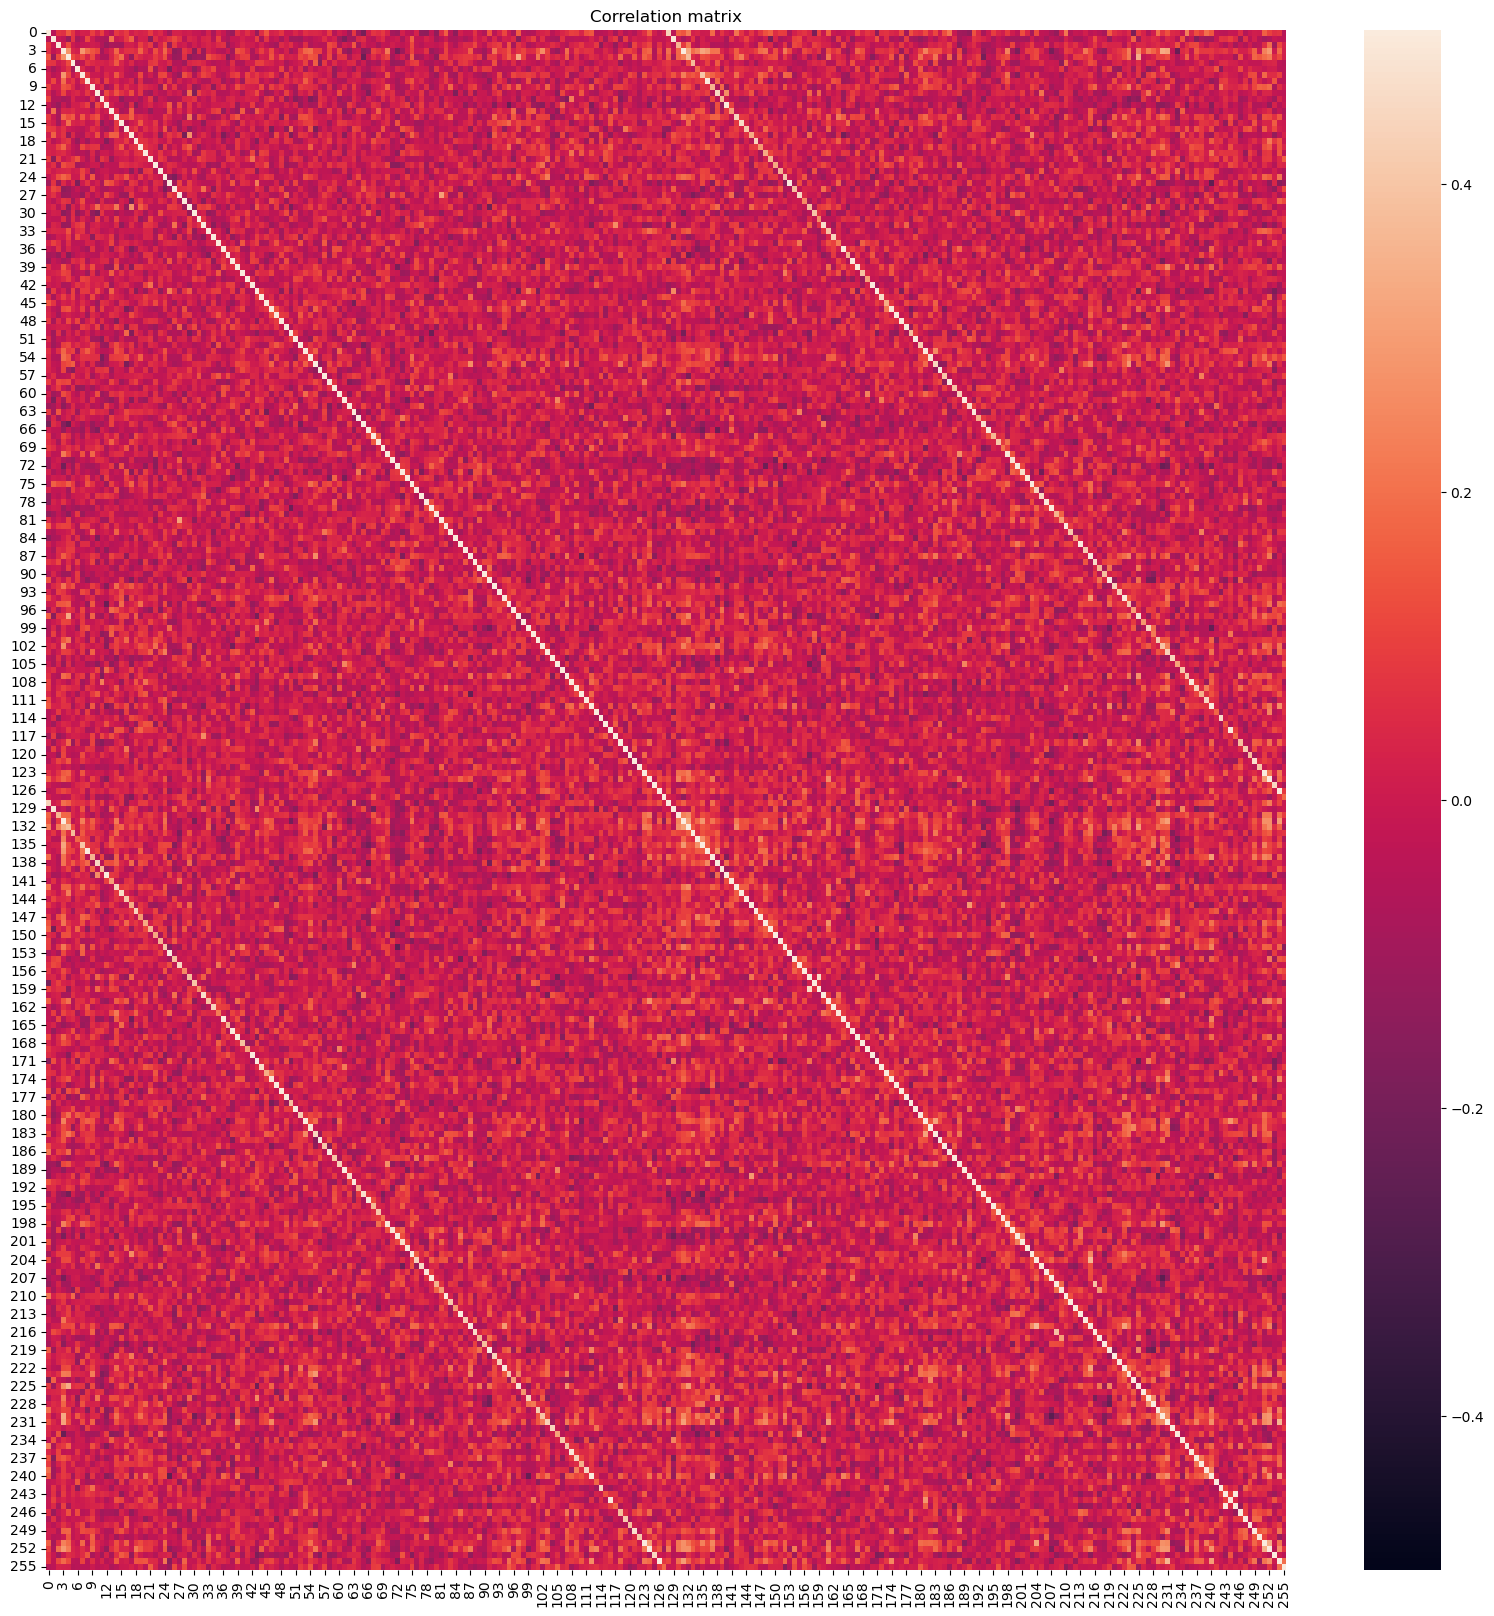

Analyzing sentence with bin len penalty 0.0


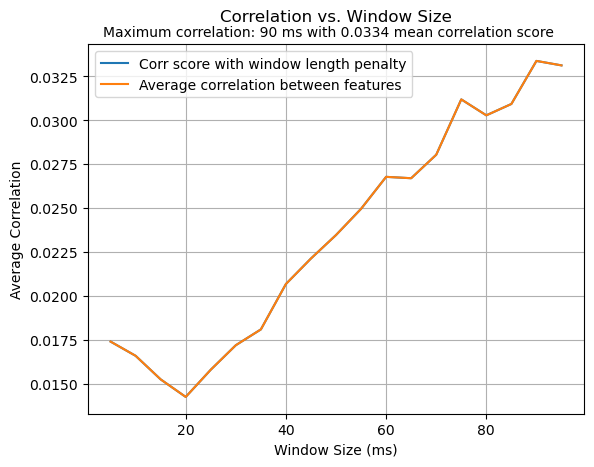

PCA features
50% of data: 8, 95% of data: 44
Analyzing sentence with bin len penalty 0.5


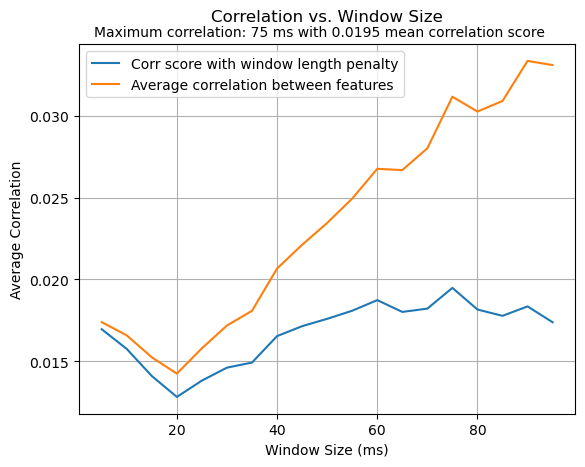

PCA features
50% of data: 10, 95% of data: 52
:::::::  ANALYZING SENTENCE #2 - Recording length: 7640 ms  :::::::


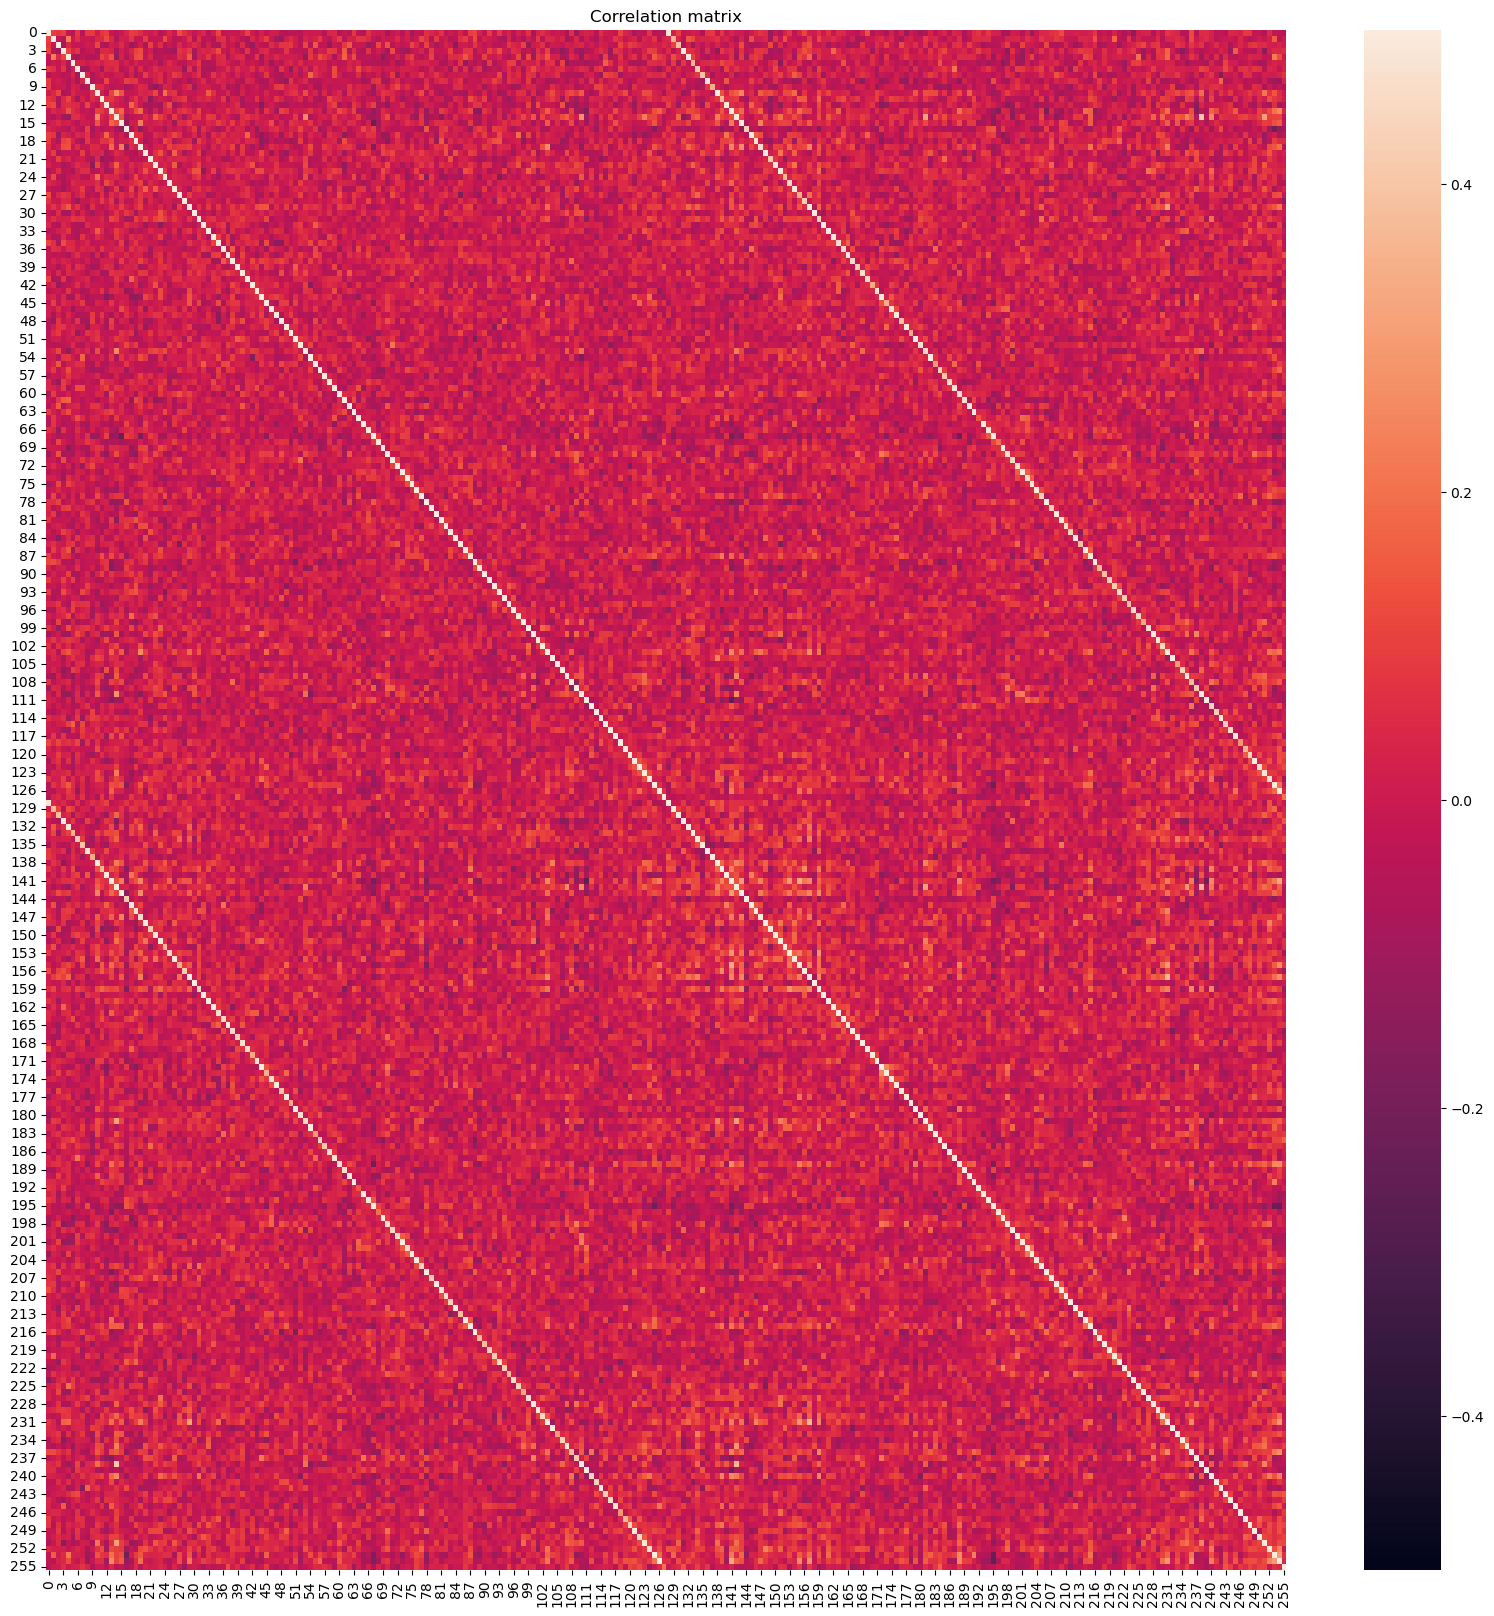

Analyzing sentence with bin len penalty 0.0


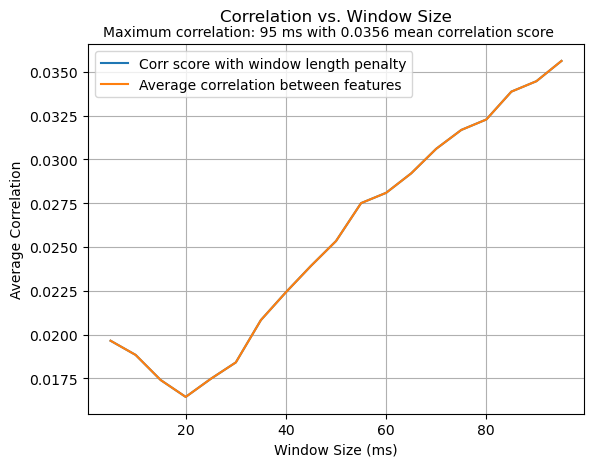

PCA features
50% of data: 12, 95% of data: 59
Analyzing sentence with bin len penalty 0.5


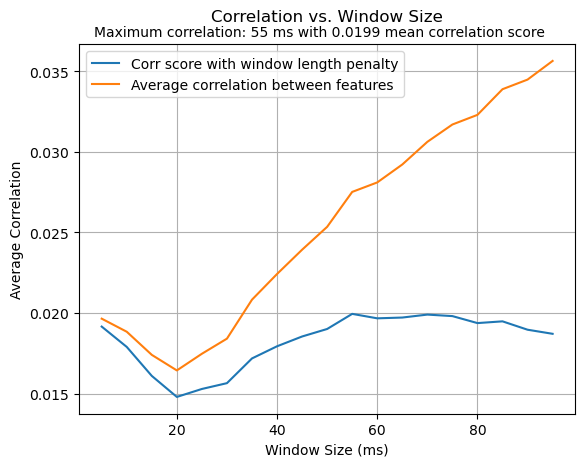

PCA features
50% of data: 20, 95% of data: 93


In [4]:
for i, sentence in enumerate(sentences):
    print(f":::::::  ANALYZING SENTENCE #{i} - Recording length: {sentence.shape[0] * 20} ms  :::::::")
    analyze_sentence(sentence, max_bin_len, True)

## Determine optimal window size for the whole data

In [5]:
train = [sample.numpy() for sample in Brain2TextDataset(config=ds_config, yaml_config=yaml_config, split="train").brain_data_samples]
val = [sample.numpy() for sample in Brain2TextDataset(config=ds_config, yaml_config=yaml_config, split="val").brain_data_samples]
test = [sample.numpy() for sample in Brain2TextDataset(config=ds_config, yaml_config=yaml_config, split="test").brain_data_samples]

all_sentences = train + val + test
len(all_sentences)

Got tokenizer from file
Got tokenizer from file
Got tokenizer from file


9680

In [6]:
limit = 200
sentence_subset = random.sample(all_sentences, k=limit)

In [7]:
results = []
for sentence_data in tqdm(sentence_subset):
    results.append(analyze_sentence(sentence_data, max_bin_len))

100%|██████████| 200/200 [04:20<00:00,  1.30s/it]


In [8]:
results_no_penalty = [(timebins[0], corr_avgs[0], pca_feats[0]) for (timebins, corr_avgs, pca_feats) in results]
results_penalty = [(timebins[1], corr_avgs[1], pca_feats[1]) for (timebins, corr_avgs, pca_feats) in results]

In [12]:
results_np_df = pd.DataFrame(results_no_penalty, columns=["time_bin_length", "avg_corr", "pca_95_feat_count"])
results_p_df = pd.DataFrame(results_penalty, columns=["time_bin_length", "avg_corr", "pca_95_feat_count"])

In [16]:
# Original data for reference
print("time_bin_length 20")
print(f"avg_corr {np.mean([np.mean(np.mean(pd.DataFrame(sentence).corr())) for sentence in sentence_subset])}")

idx_95s = []
for sentence in sentence_subset:
    df = pd.DataFrame(sentence)
    pca = PCA(n_components=min(len(df), len(df.columns)))
    pcs = pca.fit_transform(df)
    index_95 = pca_most_valuable_features(pca, 0.95)
    idx_95s.append(index_95)
print(f"pca_95_feat_count {np.mean(idx_95s)}")

time_bin_length 20


avg_corr 0.018726112042037526
pca_95_feat_count 145.46


In [13]:
results_np_df.mean()

time_bin_length      92.700000
avg_corr              0.042139
pca_95_feat_count    50.215000
dtype: float64

In [14]:
results_p_df.mean()

time_bin_length      64.850000
avg_corr              0.036895
pca_95_feat_count    70.460000
dtype: float64